In [108]:
import pickle
import sys
import numpy as np
import pandas as pd
import re
from tqdm import tqdm_notebook, trange
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import nltk

from sklearn.feature_extraction.text import CountVectorizer
import logging

In [61]:
sys.path.append('/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src')

In [62]:
import imp
import tokenizer
import w2v_preprocessing
imp.reload(w2v_preprocessing)

<module 'w2v_preprocessing' from '/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src/w2v_preprocessing.py'>

In [63]:

#from transformer import TopFrequentWordsIndexer
import transformer
imp.reload(transformer)
from nltk_sent_tokenize_binding import NLTKSentenceTokenizer

In [109]:
root_path = '/Users/ak/Yandex.Disk.localized/Магистратура ВШЭ/Chat_word_autofill/'
ver = 2
logging.basicConfig(filename='w2v_pytorch' + str(ver) + '_train.log', format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

Загрузим датафрейм с предложениями

In [65]:
data_sentences = pd.read_csv('data_sentences.csv', encoding='utf-8')

/Users/ak/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Загрузим модель и векторные представления

In [66]:
with open('model_tokenize.pkl', 'rb') as f:
    model = pickle.load(f)
with open('data_tokenized.pkl', 'rb') as f:
    X_idx = pickle.load(f)

Функция, сопоставляющая каждому слову контекст из предыдущих слов длиной context_size

In [68]:
def get_sequences(seq, context_size):
    padded_seq = [0 for i in range(context_size)]
    padded_seq.extend(seq)
    #print(padded_seq)
    contexts = []
    for i in range(len(seq)):
        contexts.append(padded_seq[i:i + context_size])
    return contexts

Получим контексты для каждого слова. 

Так как применяется заполнение нулями слева и справа на длину контекста, то для каждого слова в предложении определены и контекст после, и контекст перед

In [69]:
pre_contexts = []
post_contexts = []
targets = []
context_size = 3
for x in tqdm_notebook(X_idx):
    pre_context = get_sequences(x, context_size)
    post_context = list(reversed(get_sequences(list(reversed(x)), context_size)))
    pre_contexts.extend(pre_context)
    post_contexts.extend(post_context)
    targets.extend(x)

HBox(children=(IntProgress(value=0, max=586643), HTML(value='')))

Exception in thread Thread-33:
Traceback (most recent call last):
  File "/Users/ak/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ak/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/ak/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Собственно обучение word2vec

In [72]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime, timedelta
from  IPython.display import clear_output
use_gpu = torch.cuda.is_available()

Загрузим датасет в тензоры

In [73]:
pre = torch.LongTensor(pre_contexts)

In [74]:
post = torch.LongTensor(post_contexts)

In [75]:
context = torch.cat([pre, post], dim=1)
context.shape

torch.Size([4505730, 6])

In [76]:
target = torch.LongTensor(targets)
target.shape

torch.Size([4505730])

Функция, выдающая подвыборки длины batchsize

In [77]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            #excerpt = list(sorted(indices[start_idx:start_idx + batchsize]))
            excerpt = torch.from_numpy(np.sort(indices[start_idx:start_idx + batchsize]))
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Модель. Leaky ReLU применен потому, что с обычным функция потерь менялась как в GAN

In [80]:
class NGramLanguageModelerLeaky(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size=128):
        super(NGramLanguageModelerLeaky, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * 2 * context_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        #print(inputs.shape)
        embeds = self.embeddings(inputs)
        #print(embeds.shape)
        out = self.linear1(embeds.view(-1, embedding_dim * 2 * context_size))
        #print(out.shape)
        out = F.leaky_relu(out)
        out = self.linear2(out)
        #print(out.shape)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

  0%|          | 6/2200 [00:29<2:59:15,  4.90s/it]

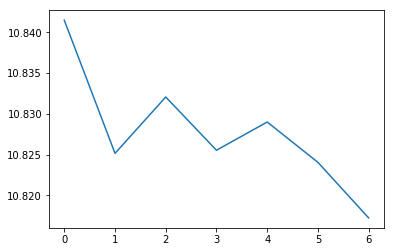

  1%|          | 13/2200 [01:01<2:51:40,  4.71s/it]

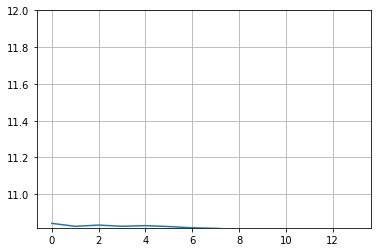

  1%|          | 21/2200 [01:33<2:41:27,  4.45s/it]

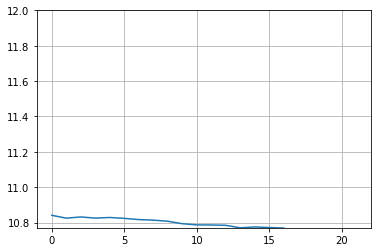

  1%|▏         | 29/2200 [02:04<2:34:43,  4.28s/it]

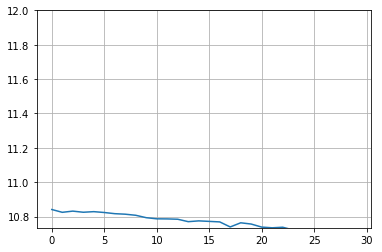

  2%|▏         | 37/2200 [02:35<2:31:06,  4.19s/it]

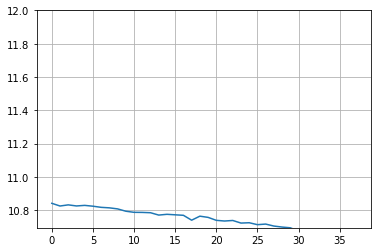

  2%|▏         | 44/2200 [03:06<2:32:20,  4.24s/it]

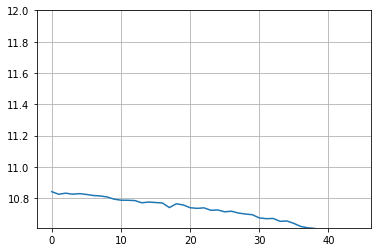

  2%|▏         | 52/2200 [03:39<2:30:59,  4.22s/it]

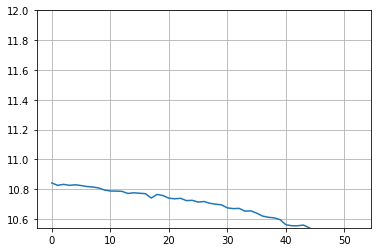

  3%|▎         | 60/2200 [04:10<2:28:41,  4.17s/it]

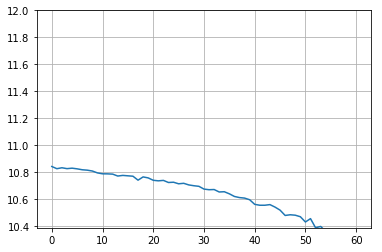

  3%|▎         | 67/2200 [04:40<2:28:53,  4.19s/it]

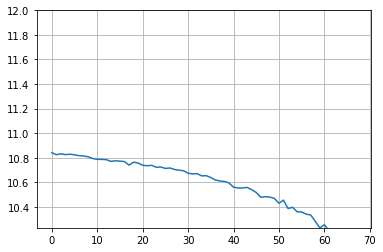

  3%|▎         | 75/2200 [05:13<2:27:48,  4.17s/it]

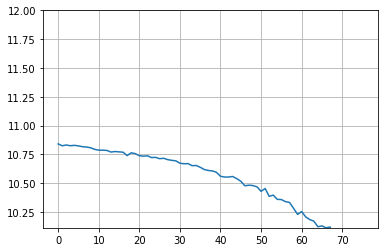

  4%|▎         | 82/2200 [05:44<2:28:14,  4.20s/it]

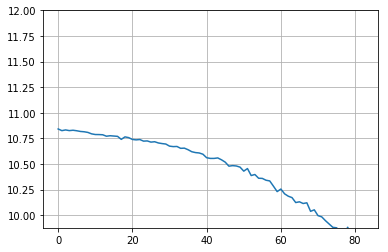

  4%|▍         | 90/2200 [06:17<2:27:30,  4.19s/it]

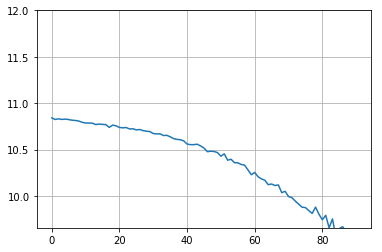

  4%|▍         | 97/2200 [06:46<2:26:44,  4.19s/it]

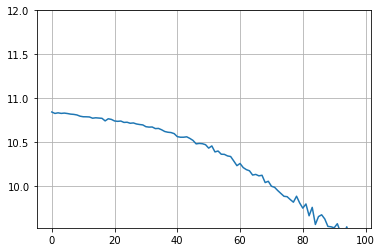

  5%|▍         | 104/2200 [07:21<2:28:16,  4.24s/it]

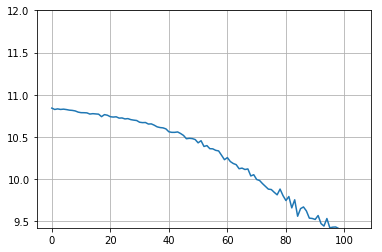

  5%|▌         | 112/2200 [07:55<2:27:53,  4.25s/it]

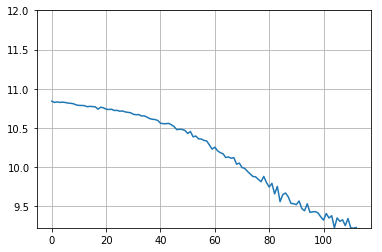

  5%|▌         | 120/2200 [08:28<2:26:54,  4.24s/it]

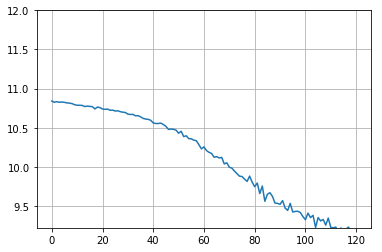

  6%|▌         | 127/2200 [09:00<2:26:56,  4.25s/it]

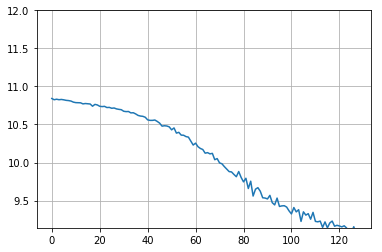

  6%|▌         | 135/2200 [09:32<2:26:01,  4.24s/it]

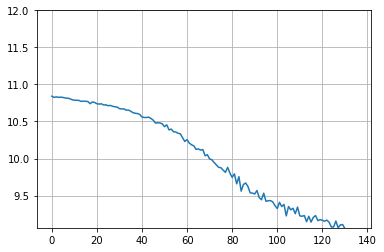

  6%|▋         | 143/2200 [10:05<2:25:11,  4.24s/it]

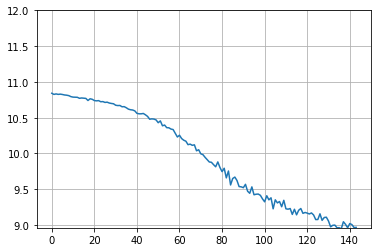

  7%|▋         | 151/2200 [10:38<2:24:20,  4.23s/it]

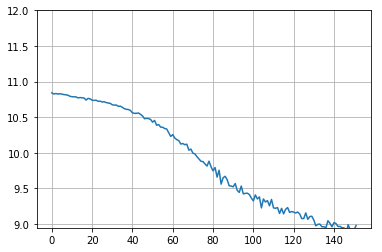

  7%|▋         | 158/2200 [11:10<2:24:24,  4.24s/it]

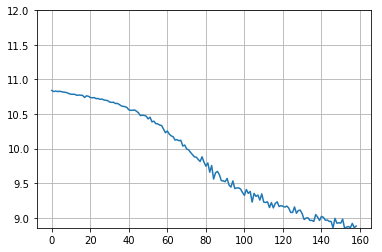

  8%|▊         | 166/2200 [11:45<2:24:00,  4.25s/it]

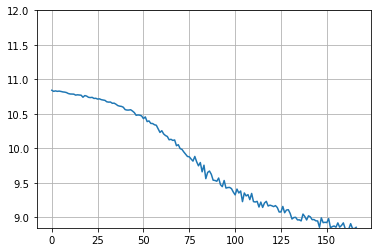

  8%|▊         | 173/2200 [12:17<2:24:02,  4.26s/it]

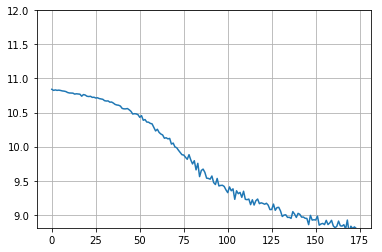

  8%|▊         | 181/2200 [12:50<2:23:10,  4.25s/it]

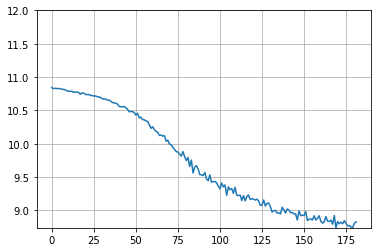

  9%|▊         | 189/2200 [13:22<2:22:23,  4.25s/it]

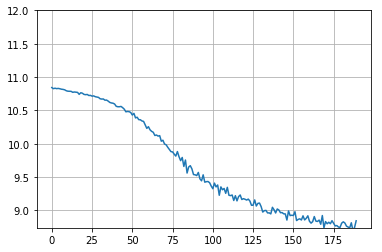

  9%|▉         | 197/2200 [13:56<2:21:42,  4.24s/it]

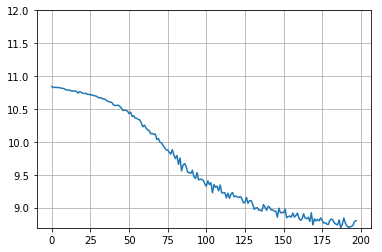

  9%|▉         | 205/2200 [14:29<2:21:00,  4.24s/it]

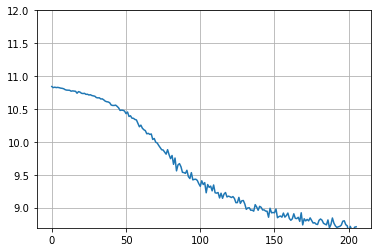

 10%|▉         | 213/2200 [15:02<2:20:18,  4.24s/it]

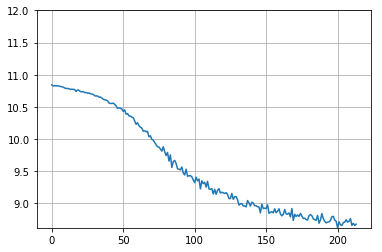

 10%|█         | 221/2200 [15:34<2:19:26,  4.23s/it]

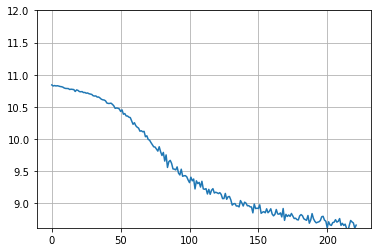

 10%|█         | 229/2200 [16:06<2:18:41,  4.22s/it]

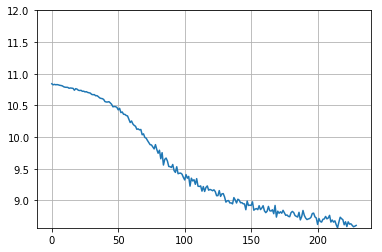

 11%|█         | 237/2200 [16:41<2:18:12,  4.22s/it]

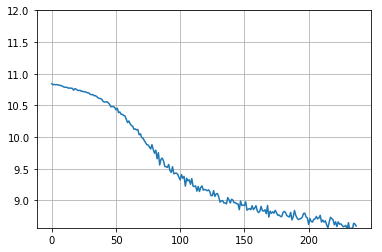

 11%|█         | 244/2200 [17:14<2:18:13,  4.24s/it]

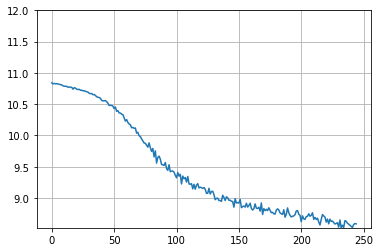

 11%|█▏        | 252/2200 [17:47<2:17:33,  4.24s/it]

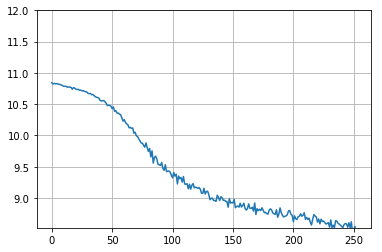

 12%|█▏        | 260/2200 [18:19<2:16:44,  4.23s/it]

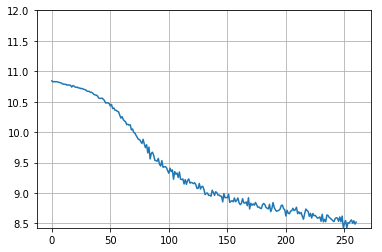

 12%|█▏        | 268/2200 [18:52<2:16:05,  4.23s/it]

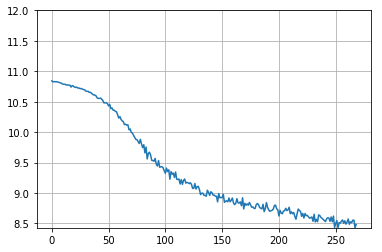

 12%|█▎        | 275/2200 [19:22<2:15:40,  4.23s/it]

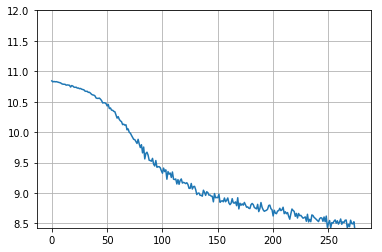

 13%|█▎        | 283/2200 [19:56<2:15:02,  4.23s/it]

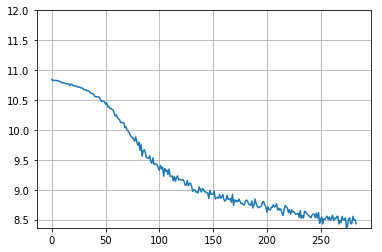

 13%|█▎        | 291/2200 [20:27<2:14:12,  4.22s/it]

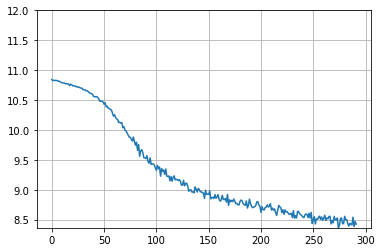

 14%|█▎        | 299/2200 [21:00<2:13:35,  4.22s/it]

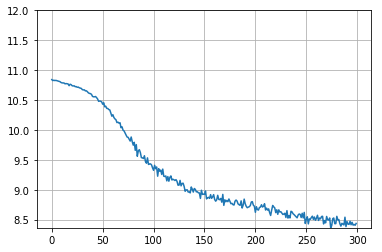

 14%|█▍        | 307/2200 [21:31<2:12:42,  4.21s/it]

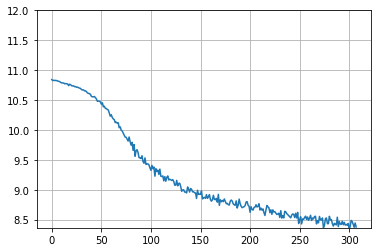

 14%|█▍        | 315/2200 [22:02<2:11:56,  4.20s/it]

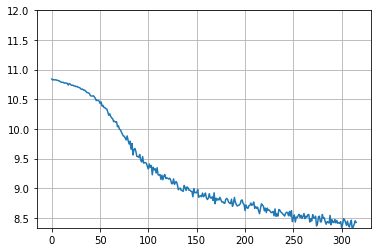

 15%|█▍        | 323/2200 [22:34<2:11:11,  4.19s/it]

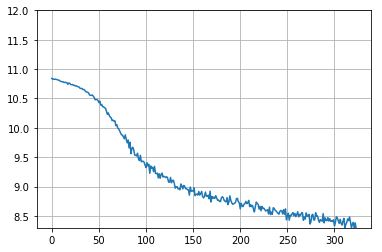

 15%|█▌        | 330/2200 [23:05<2:10:49,  4.20s/it]

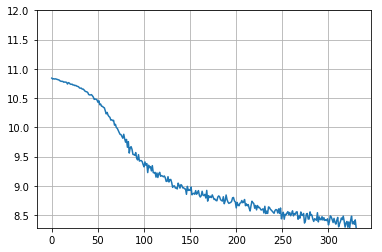

 15%|█▌        | 338/2200 [23:37<2:10:08,  4.19s/it]

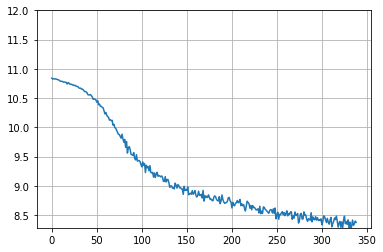

 16%|█▌        | 346/2200 [24:09<2:09:25,  4.19s/it]

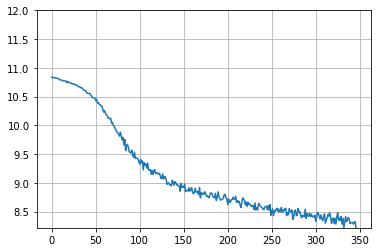

 16%|█▌        | 354/2200 [24:40<2:08:41,  4.18s/it]

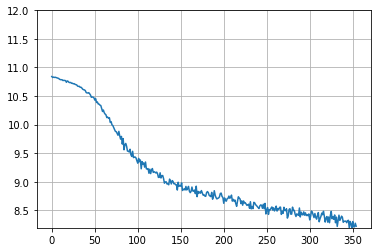

 16%|█▋        | 362/2200 [25:13<2:08:03,  4.18s/it]

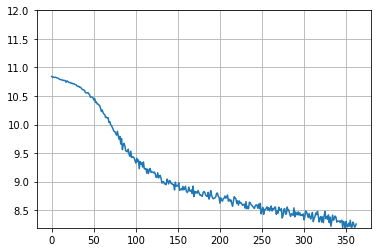

 17%|█▋        | 370/2200 [25:44<2:07:18,  4.17s/it]

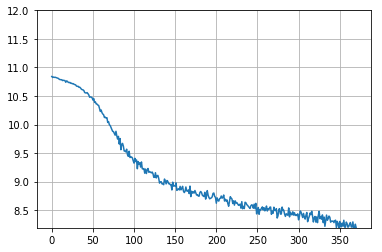

 17%|█▋        | 378/2200 [26:15<2:06:35,  4.17s/it]

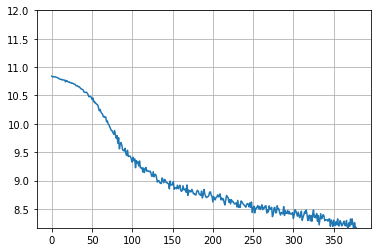

 18%|█▊        | 386/2200 [26:48<2:06:01,  4.17s/it]

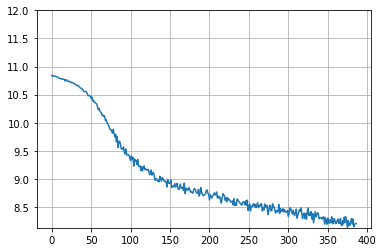

 18%|█▊        | 394/2200 [27:20<2:05:21,  4.16s/it]

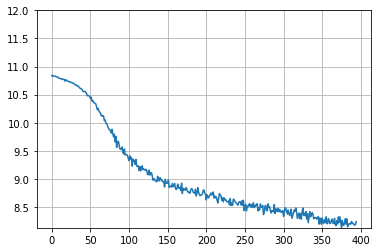

 18%|█▊        | 402/2200 [27:54<2:04:47,  4.16s/it]

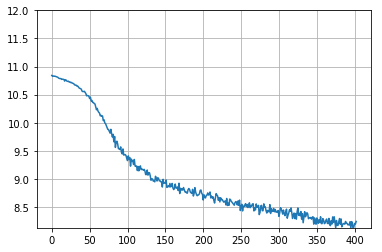

 19%|█▊        | 410/2200 [28:26<2:04:12,  4.16s/it]

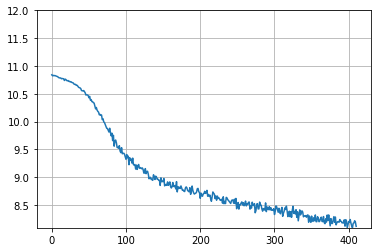

 19%|█▉        | 418/2200 [28:59<2:03:35,  4.16s/it]

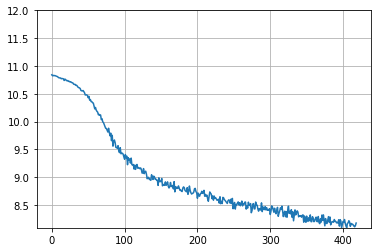

 19%|█▉        | 426/2200 [29:32<2:02:59,  4.16s/it]

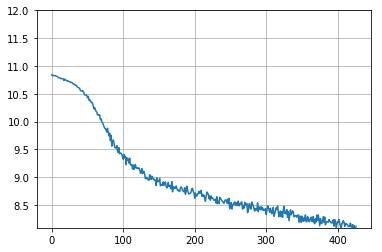

 20%|█▉        | 434/2200 [30:05<2:02:25,  4.16s/it]

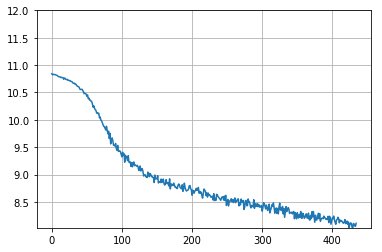

 20%|██        | 442/2200 [30:36<2:01:45,  4.16s/it]

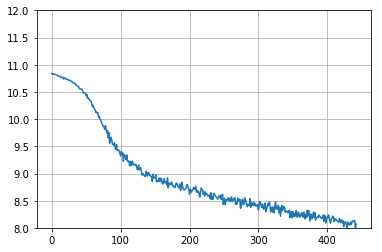

 20%|██        | 450/2200 [31:09<2:01:10,  4.15s/it]

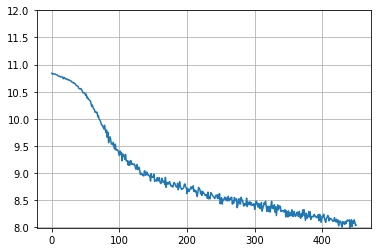

 21%|██        | 457/2200 [31:41<2:00:51,  4.16s/it]

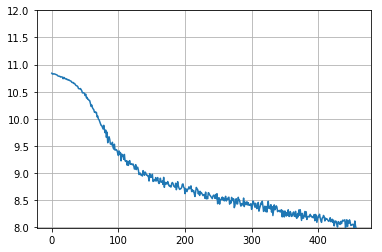

 21%|██        | 465/2200 [32:14<2:00:16,  4.16s/it]

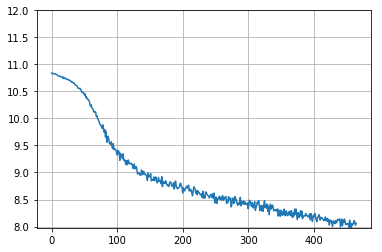

 22%|██▏       | 473/2200 [32:45<1:59:36,  4.16s/it]

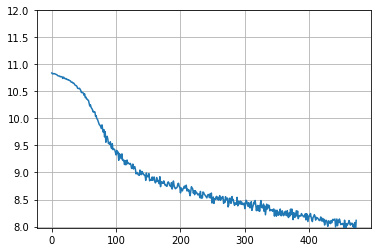

 22%|██▏       | 481/2200 [33:18<1:59:02,  4.15s/it]

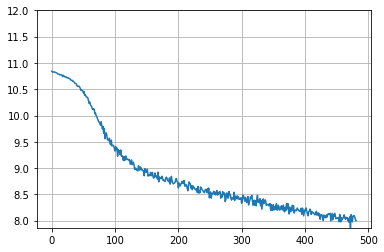

 22%|██▏       | 489/2200 [33:50<1:58:25,  4.15s/it]

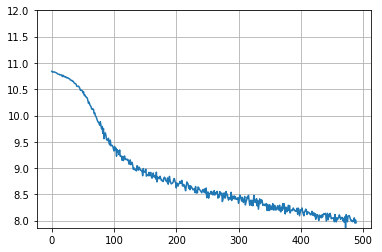

 23%|██▎       | 497/2200 [34:22<1:57:48,  4.15s/it]

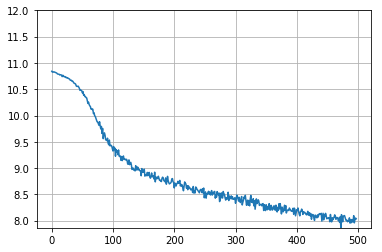

 23%|██▎       | 505/2200 [34:56<1:57:15,  4.15s/it]

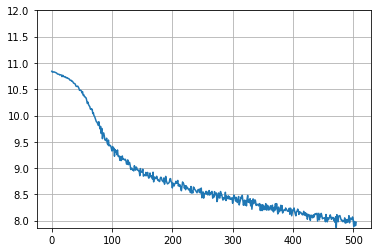

 23%|██▎       | 513/2200 [35:28<1:56:39,  4.15s/it]

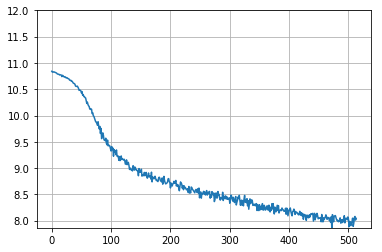

 24%|██▎       | 521/2200 [36:01<1:56:04,  4.15s/it]

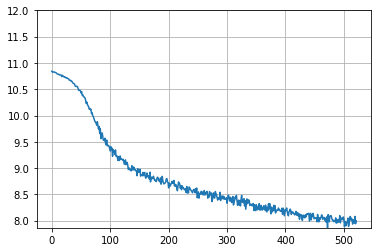

 24%|██▍       | 529/2200 [36:32<1:55:25,  4.14s/it]

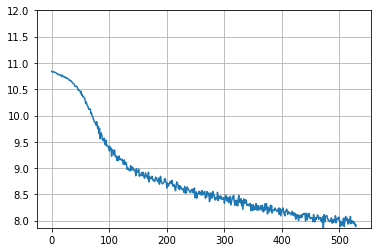

 24%|██▍       | 537/2200 [37:03<1:54:44,  4.14s/it]

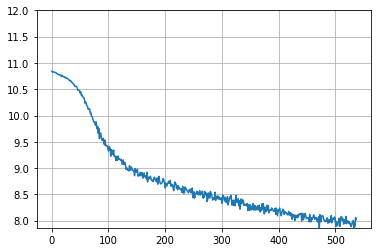

 25%|██▍       | 546/2200 [37:34<1:53:50,  4.13s/it]

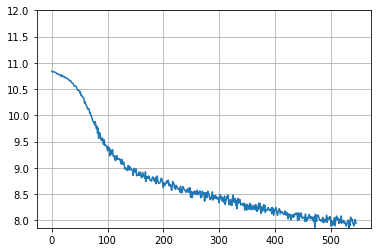

 25%|██▌       | 555/2200 [38:06<1:52:57,  4.12s/it]

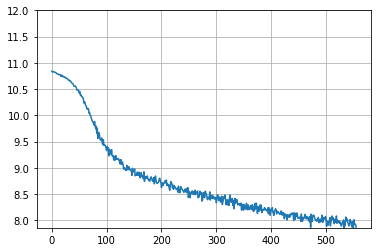

 26%|██▌       | 564/2200 [38:38<1:52:04,  4.11s/it]

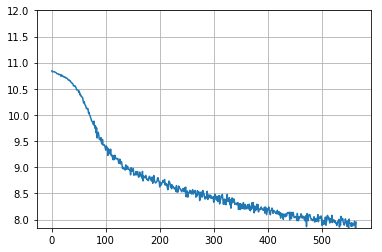

 26%|██▌       | 573/2200 [39:10<1:51:13,  4.10s/it]

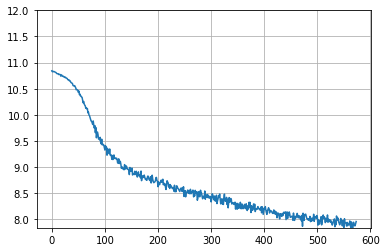

 26%|██▋       | 582/2200 [39:41<1:50:22,  4.09s/it]

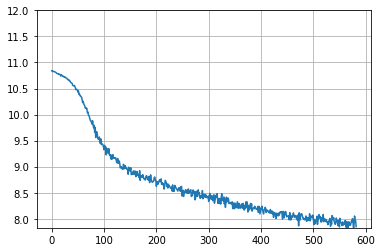

 27%|██▋       | 591/2200 [40:14<1:49:32,  4.09s/it]

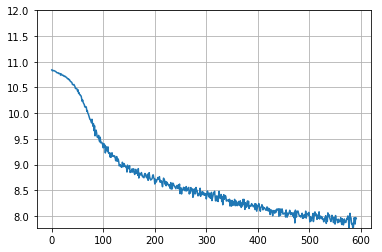

 27%|██▋       | 600/2200 [40:45<1:48:42,  4.08s/it]

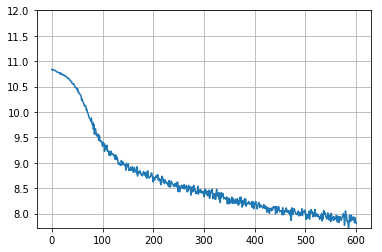

 28%|██▊       | 609/2200 [41:17<1:47:53,  4.07s/it]

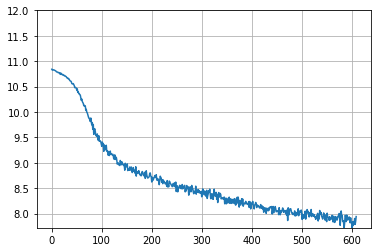

 28%|██▊       | 617/2200 [41:48<1:47:16,  4.07s/it]

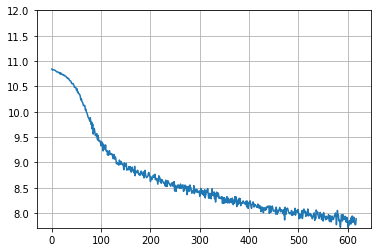

 28%|██▊       | 625/2200 [42:19<1:46:39,  4.06s/it]

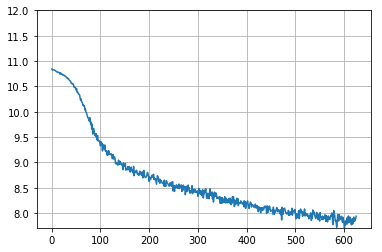

 29%|██▉       | 634/2200 [42:51<1:45:52,  4.06s/it]

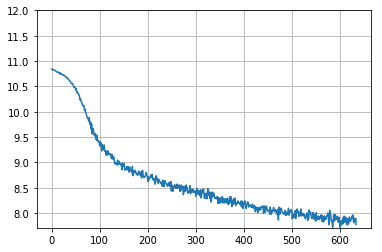

 29%|██▉       | 643/2200 [43:24<1:45:05,  4.05s/it]

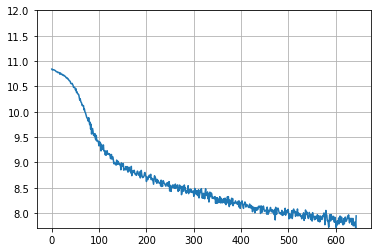

 30%|██▉       | 652/2200 [43:56<1:44:19,  4.04s/it]

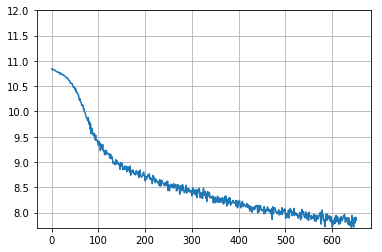

 30%|███       | 661/2200 [44:28<1:43:32,  4.04s/it]

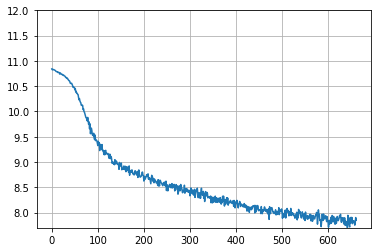

 30%|███       | 670/2200 [44:59<1:42:44,  4.03s/it]

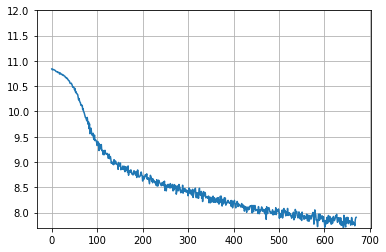

 31%|███       | 679/2200 [45:31<1:41:58,  4.02s/it]

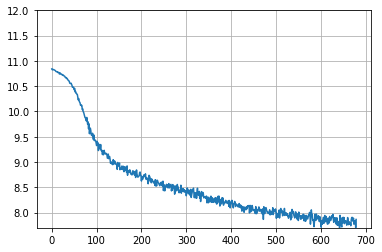

 31%|███▏      | 688/2200 [46:03<1:41:12,  4.02s/it]

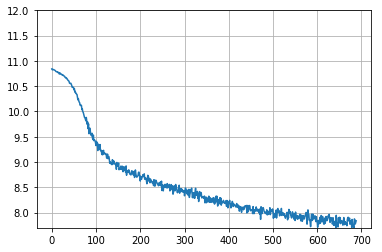

 32%|███▏      | 697/2200 [46:35<1:40:28,  4.01s/it]

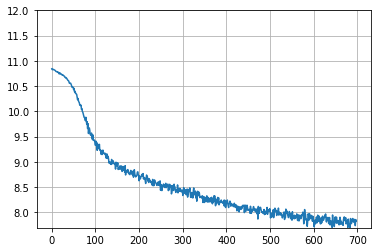

 32%|███▏      | 706/2200 [47:07<1:39:43,  4.00s/it]

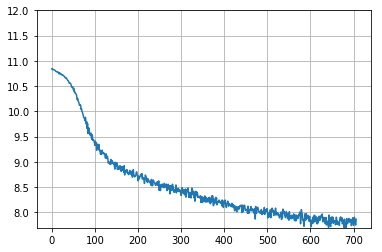

 32%|███▎      | 715/2200 [47:38<1:38:57,  4.00s/it]

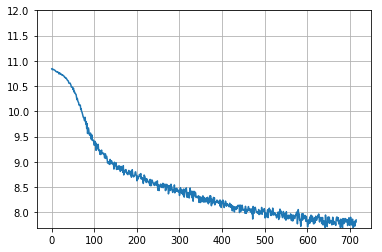

 33%|███▎      | 724/2200 [48:10<1:38:12,  3.99s/it]

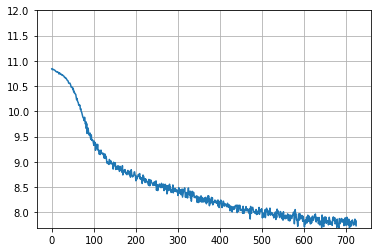

 33%|███▎      | 733/2200 [48:42<1:37:28,  3.99s/it]

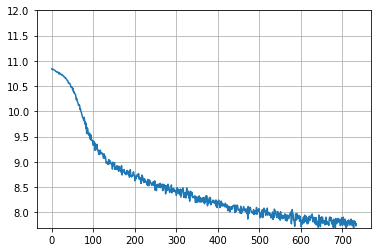

 34%|███▎      | 742/2200 [49:14<1:36:46,  3.98s/it]

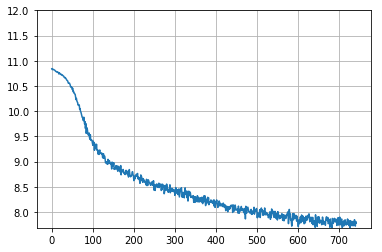

 34%|███▍      | 751/2200 [49:46<1:36:02,  3.98s/it]

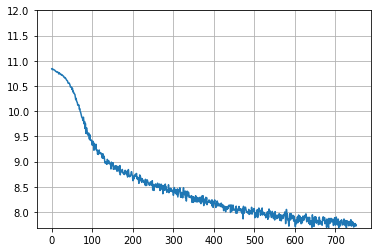

 35%|███▍      | 760/2200 [50:18<1:35:19,  3.97s/it]

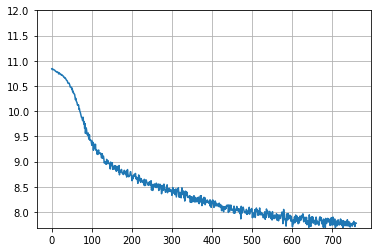

 35%|███▍      | 769/2200 [50:50<1:34:36,  3.97s/it]

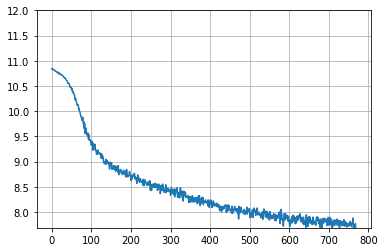

 35%|███▌      | 778/2200 [51:22<1:33:54,  3.96s/it]

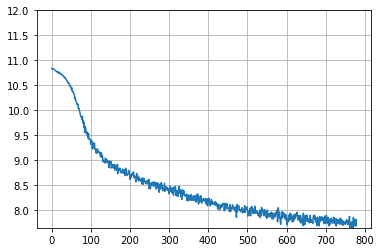

 36%|███▌      | 787/2200 [51:54<1:33:11,  3.96s/it]

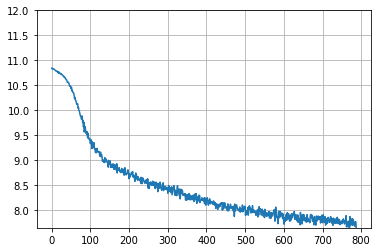

 36%|███▌      | 796/2200 [52:26<1:32:29,  3.95s/it]

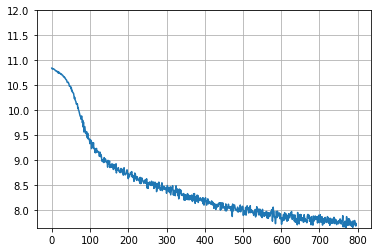

 37%|███▋      | 805/2200 [52:58<1:31:47,  3.95s/it]

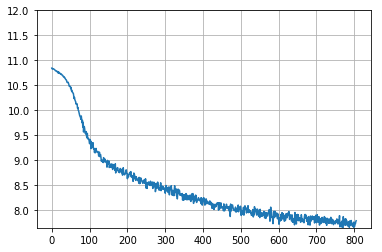

 37%|███▋      | 814/2200 [53:29<1:31:05,  3.94s/it]

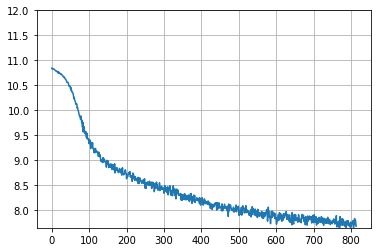

 37%|███▋      | 823/2200 [54:01<1:30:23,  3.94s/it]

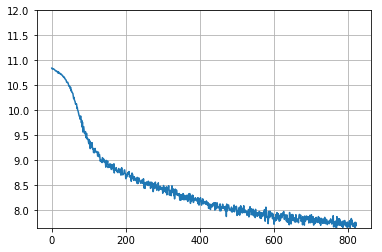

 38%|███▊      | 832/2200 [54:33<1:29:41,  3.93s/it]

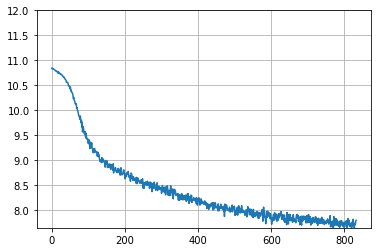

 38%|███▊      | 841/2200 [55:04<1:29:00,  3.93s/it]

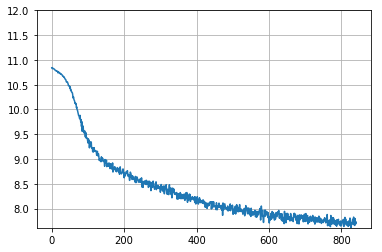

 39%|███▊      | 850/2200 [55:36<1:28:19,  3.93s/it]

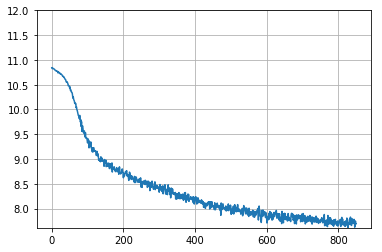

 39%|███▉      | 859/2200 [56:08<1:27:38,  3.92s/it]

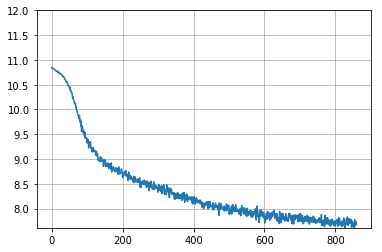

 39%|███▉      | 868/2200 [56:40<1:26:58,  3.92s/it]

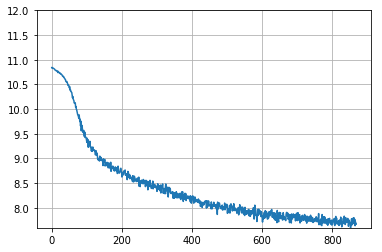

 40%|███▉      | 877/2200 [57:12<1:26:18,  3.91s/it]

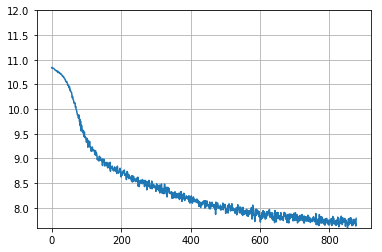

 40%|████      | 886/2200 [57:44<1:25:38,  3.91s/it]

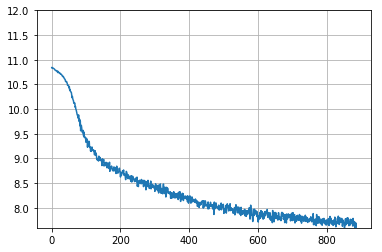

 41%|████      | 895/2200 [58:16<1:24:58,  3.91s/it]

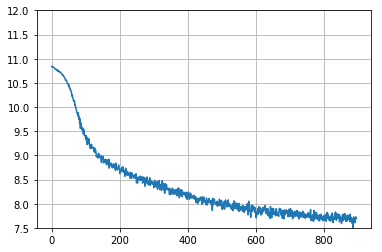

 41%|████      | 904/2200 [58:48<1:24:18,  3.90s/it]

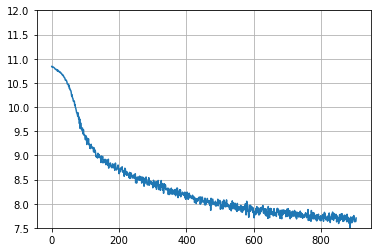

 42%|████▏     | 913/2200 [59:20<1:23:39,  3.90s/it]

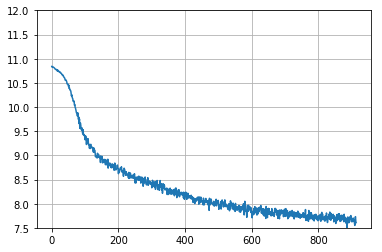

 42%|████▏     | 922/2200 [59:52<1:22:59,  3.90s/it]

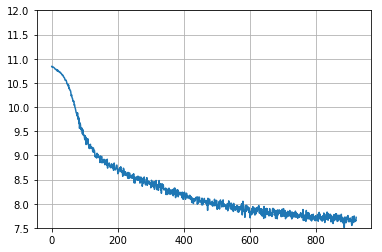

 42%|████▏     | 931/2200 [1:00:23<1:22:19,  3.89s/it]

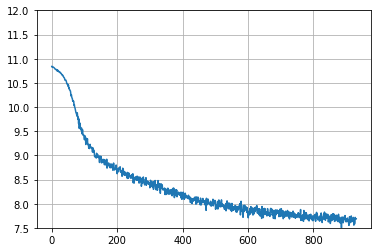

 43%|████▎     | 940/2200 [1:00:55<1:21:39,  3.89s/it]

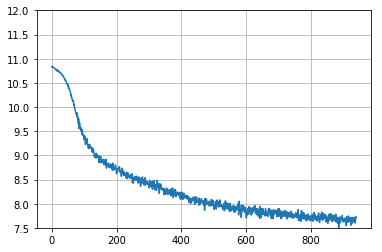

 43%|████▎     | 949/2200 [1:01:27<1:21:01,  3.89s/it]

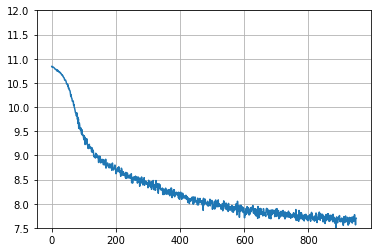

 44%|████▎     | 958/2200 [1:01:59<1:20:22,  3.88s/it]

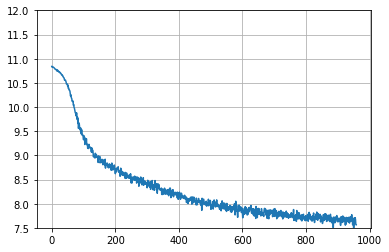

 44%|████▍     | 967/2200 [1:02:31<1:19:43,  3.88s/it]

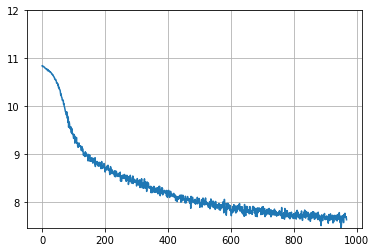

 44%|████▍     | 976/2200 [1:03:03<1:19:04,  3.88s/it]

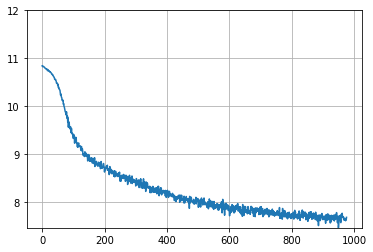

 45%|████▍     | 985/2200 [1:03:35<1:18:25,  3.87s/it]

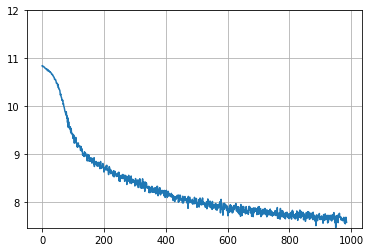

 45%|████▌     | 994/2200 [1:04:06<1:17:47,  3.87s/it]

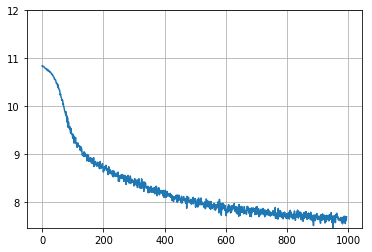

 46%|████▌     | 1003/2200 [1:04:38<1:17:08,  3.87s/it]

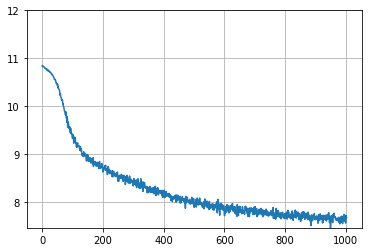

 46%|████▌     | 1012/2200 [1:05:09<1:16:29,  3.86s/it]

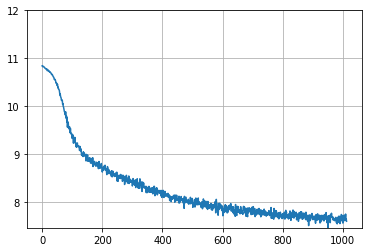

 46%|████▋     | 1021/2200 [1:05:41<1:15:51,  3.86s/it]

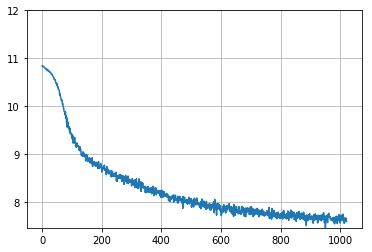

 47%|████▋     | 1030/2200 [1:06:13<1:15:13,  3.86s/it]

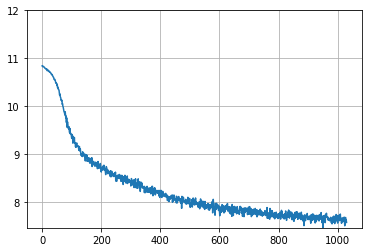

 47%|████▋     | 1039/2200 [1:06:45<1:14:35,  3.85s/it]

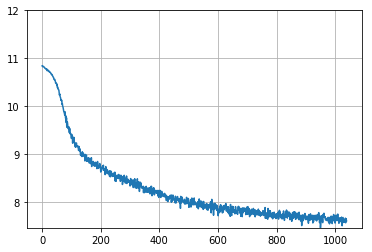

 48%|████▊     | 1048/2200 [1:07:17<1:13:57,  3.85s/it]

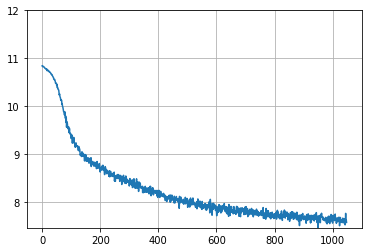

 48%|████▊     | 1057/2200 [1:07:49<1:13:20,  3.85s/it]

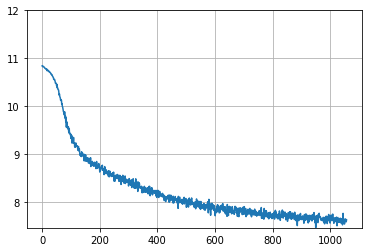

 48%|████▊     | 1066/2200 [1:08:21<1:12:42,  3.85s/it]

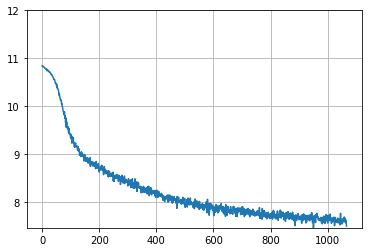

 49%|████▉     | 1075/2200 [1:08:53<1:12:05,  3.84s/it]

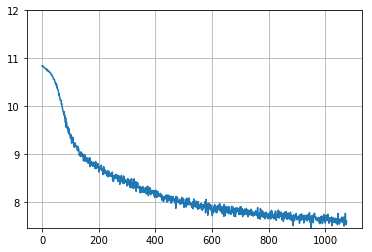

 49%|████▉     | 1084/2200 [1:09:24<1:11:27,  3.84s/it]

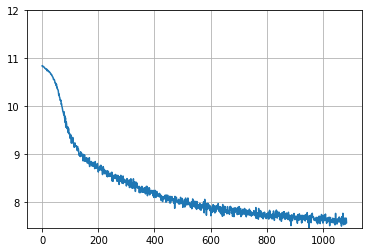

 50%|████▉     | 1093/2200 [1:09:56<1:10:50,  3.84s/it]

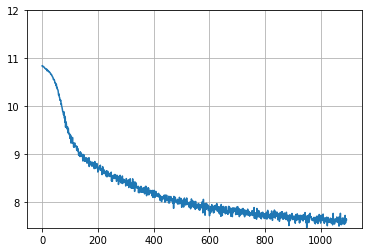

 50%|█████     | 1102/2200 [1:10:28<1:10:13,  3.84s/it]

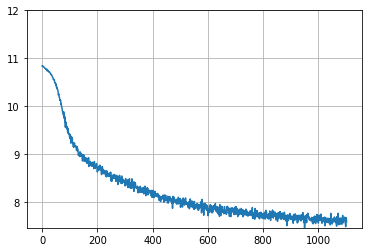

 50%|█████     | 1111/2200 [1:11:00<1:09:36,  3.84s/it]

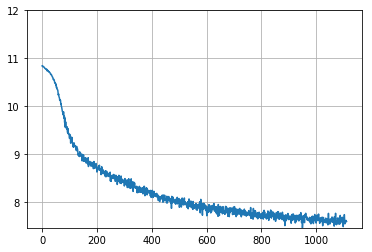

 51%|█████     | 1120/2200 [1:11:32<1:08:59,  3.83s/it]

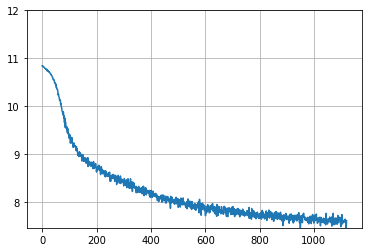

 51%|█████▏    | 1129/2200 [1:12:04<1:08:22,  3.83s/it]

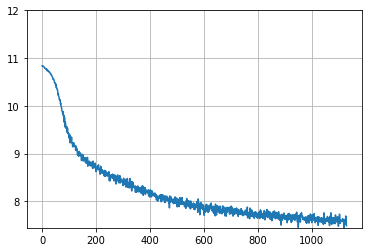

 52%|█████▏    | 1138/2200 [1:12:36<1:07:45,  3.83s/it]

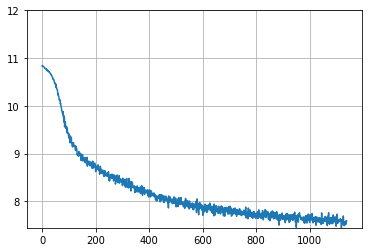

 52%|█████▏    | 1147/2200 [1:13:08<1:07:08,  3.83s/it]

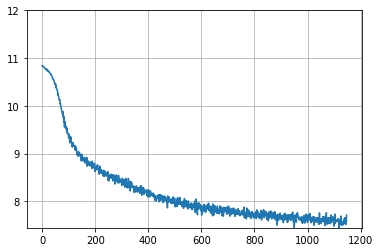

 53%|█████▎    | 1156/2200 [1:13:40<1:06:31,  3.82s/it]

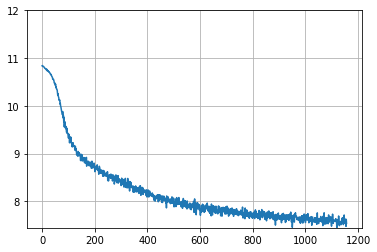

 53%|█████▎    | 1165/2200 [1:14:12<1:05:55,  3.82s/it]

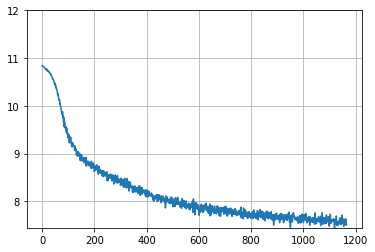

 53%|█████▎    | 1174/2200 [1:14:44<1:05:18,  3.82s/it]

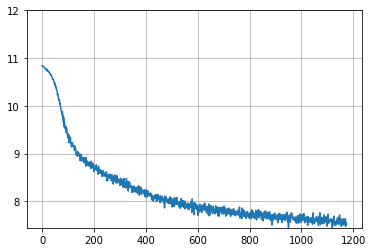

 54%|█████▍    | 1183/2200 [1:15:15<1:04:42,  3.82s/it]

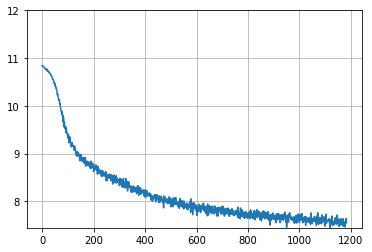

 54%|█████▍    | 1192/2200 [1:15:47<1:04:05,  3.82s/it]

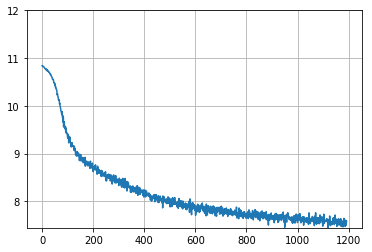

 55%|█████▍    | 1201/2200 [1:16:19<1:03:29,  3.81s/it]

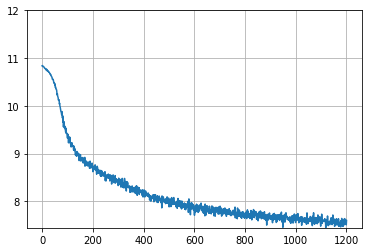

 55%|█████▌    | 1210/2200 [1:16:51<1:02:52,  3.81s/it]

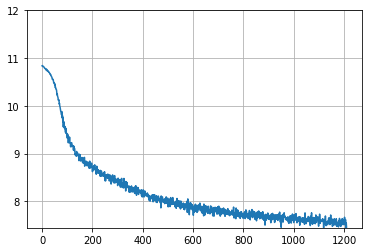

 55%|█████▌    | 1219/2200 [1:17:23<1:02:16,  3.81s/it]

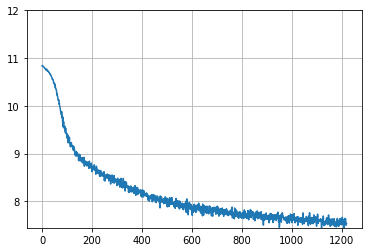

 56%|█████▌    | 1228/2200 [1:17:54<1:01:40,  3.81s/it]

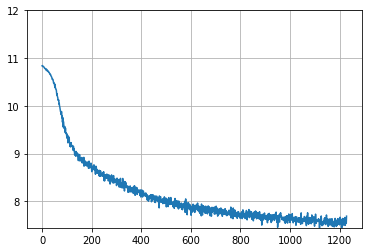

 56%|█████▌    | 1237/2200 [1:18:26<1:01:04,  3.81s/it]

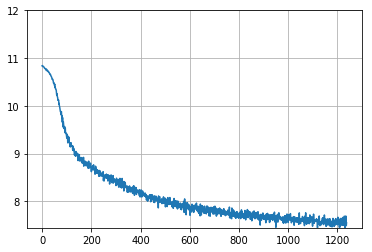

 57%|█████▋    | 1246/2200 [1:18:58<1:00:28,  3.80s/it]

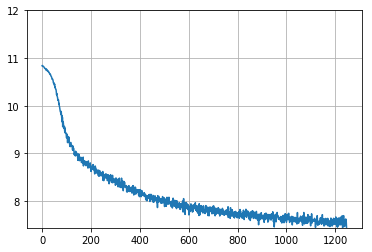

 57%|█████▋    | 1255/2200 [1:19:31<59:52,  3.80s/it]  

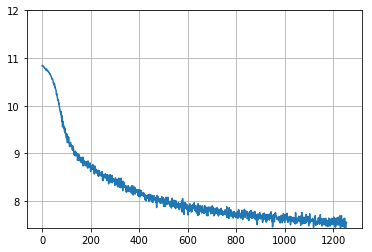

 57%|█████▋    | 1264/2200 [1:20:03<59:16,  3.80s/it]

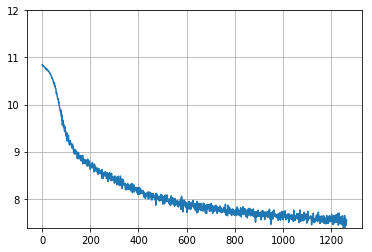

 58%|█████▊    | 1273/2200 [1:20:34<58:40,  3.80s/it]

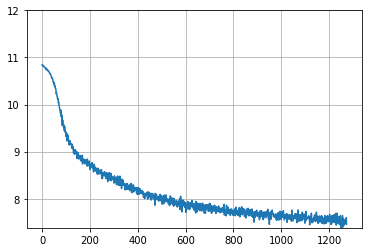

 58%|█████▊    | 1282/2200 [1:21:06<58:04,  3.80s/it]

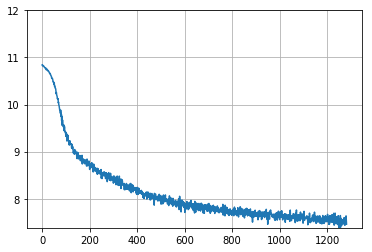

 59%|█████▊    | 1291/2200 [1:21:38<57:28,  3.79s/it]

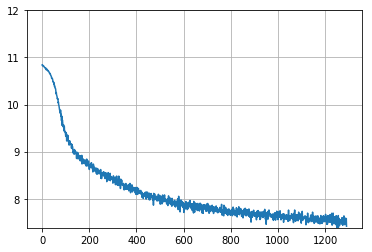

 59%|█████▉    | 1300/2200 [1:22:09<56:52,  3.79s/it]

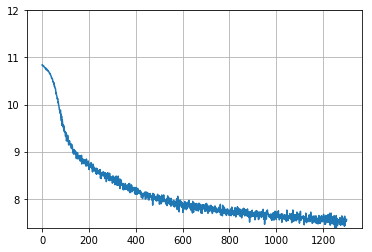

 60%|█████▉    | 1309/2200 [1:22:41<56:17,  3.79s/it]

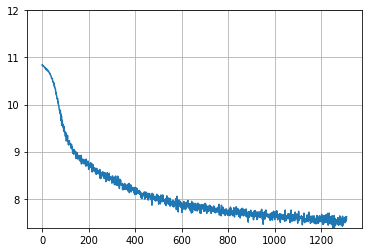

 60%|█████▉    | 1318/2200 [1:23:13<55:41,  3.79s/it]

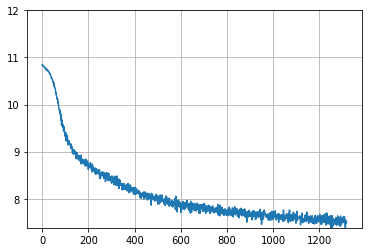

 60%|██████    | 1327/2200 [1:23:45<55:06,  3.79s/it]

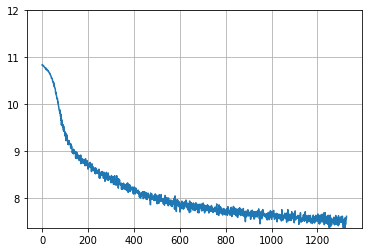

 61%|██████    | 1336/2200 [1:24:17<54:30,  3.79s/it]

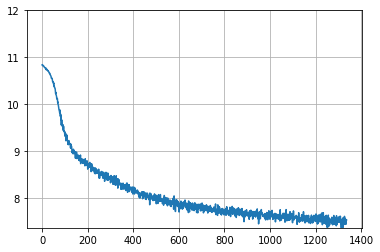

 61%|██████    | 1345/2200 [1:24:48<53:54,  3.78s/it]

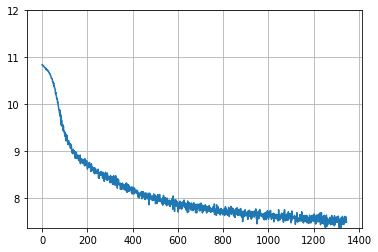

 62%|██████▏   | 1354/2200 [1:25:20<53:19,  3.78s/it]

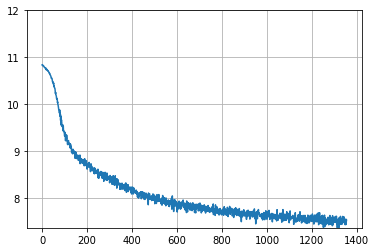

 62%|██████▏   | 1363/2200 [1:25:53<52:44,  3.78s/it]

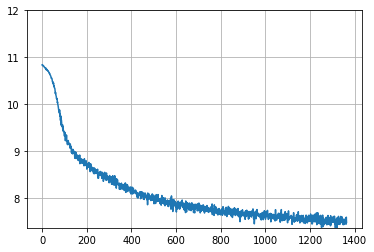

 62%|██████▏   | 1372/2200 [1:26:24<52:08,  3.78s/it]

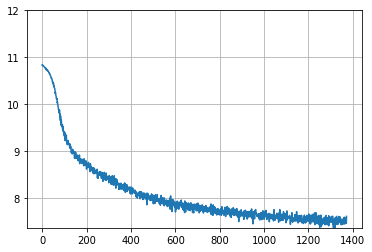

 63%|██████▎   | 1381/2200 [1:26:56<51:33,  3.78s/it]

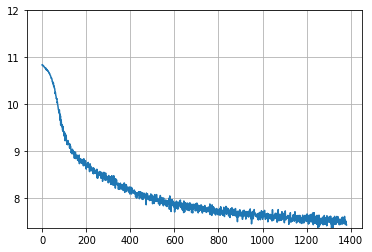

 63%|██████▎   | 1390/2200 [1:27:28<50:58,  3.78s/it]

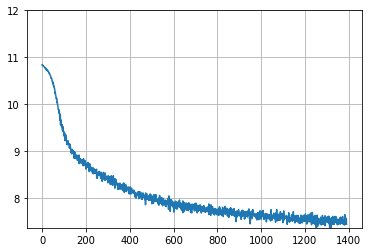

 64%|██████▎   | 1399/2200 [1:28:00<50:23,  3.77s/it]

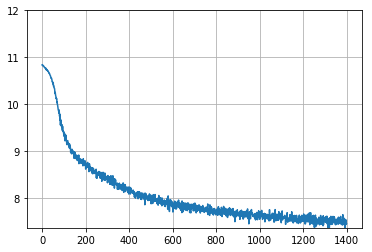

 64%|██████▍   | 1408/2200 [1:28:32<49:48,  3.77s/it]

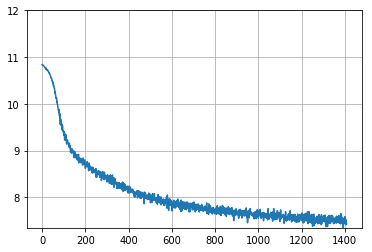

 64%|██████▍   | 1417/2200 [1:29:03<49:12,  3.77s/it]

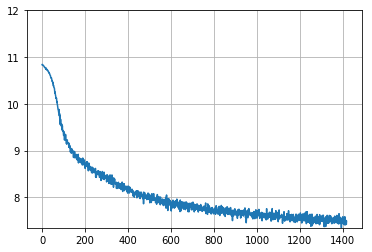

 65%|██████▍   | 1426/2200 [1:29:35<48:37,  3.77s/it]

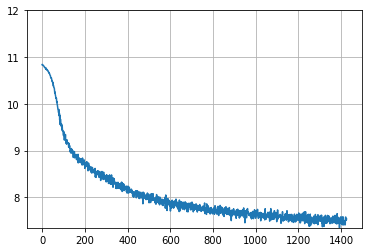

 65%|██████▌   | 1435/2200 [1:30:07<48:02,  3.77s/it]

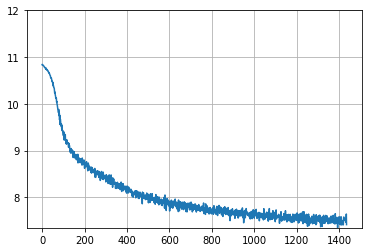

 66%|██████▌   | 1444/2200 [1:30:39<47:27,  3.77s/it]

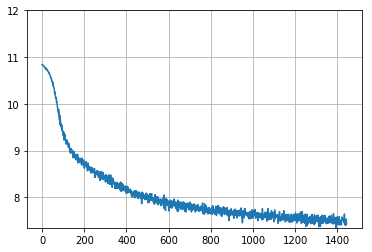

 66%|██████▌   | 1453/2200 [1:31:11<46:52,  3.77s/it]

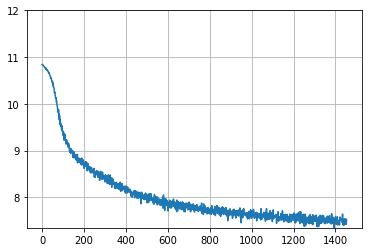

 66%|██████▋   | 1462/2200 [1:31:43<46:18,  3.76s/it]

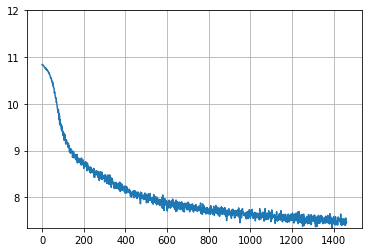

 67%|██████▋   | 1471/2200 [1:32:15<45:43,  3.76s/it]

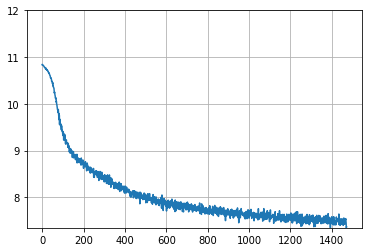

 67%|██████▋   | 1480/2200 [1:32:48<45:08,  3.76s/it]

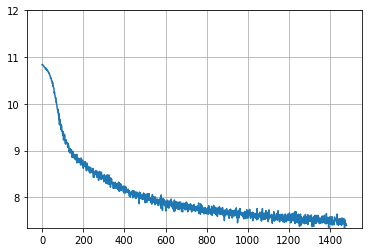

 68%|██████▊   | 1489/2200 [1:33:19<44:33,  3.76s/it]

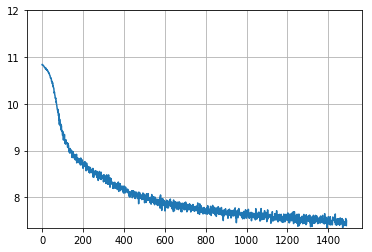

 68%|██████▊   | 1498/2200 [1:33:51<43:59,  3.76s/it]

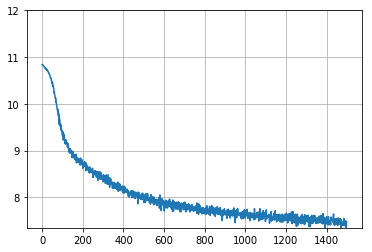

 68%|██████▊   | 1507/2200 [1:34:23<43:24,  3.76s/it]

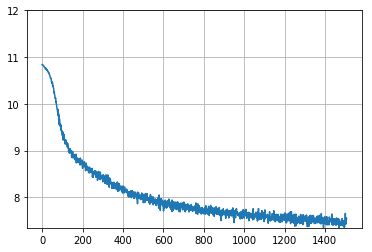

 69%|██████▉   | 1516/2200 [1:34:55<42:49,  3.76s/it]

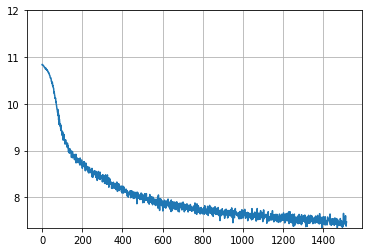

 69%|██████▉   | 1525/2200 [1:35:27<42:15,  3.76s/it]

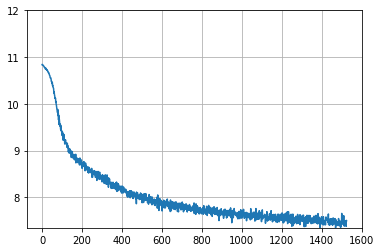

 70%|██████▉   | 1534/2200 [1:35:59<41:40,  3.75s/it]

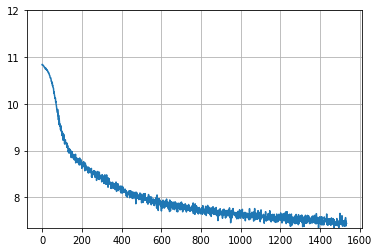

 70%|███████   | 1543/2200 [1:36:31<41:05,  3.75s/it]

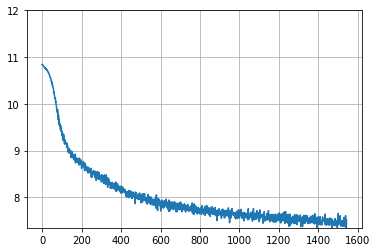

 71%|███████   | 1552/2200 [1:37:03<40:31,  3.75s/it]

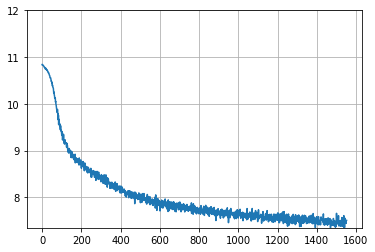

 71%|███████   | 1561/2200 [1:37:35<39:57,  3.75s/it]

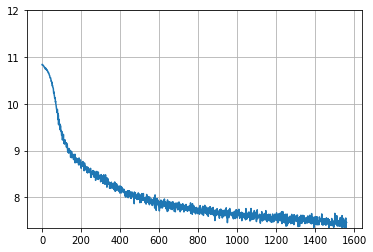

 71%|███████▏  | 1570/2200 [1:38:07<39:22,  3.75s/it]

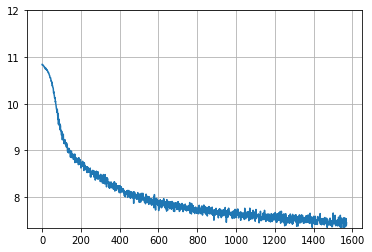

 72%|███████▏  | 1579/2200 [1:38:39<38:47,  3.75s/it]

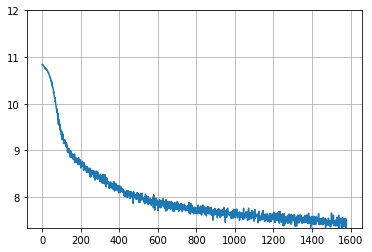

 72%|███████▏  | 1588/2200 [1:39:11<38:13,  3.75s/it]

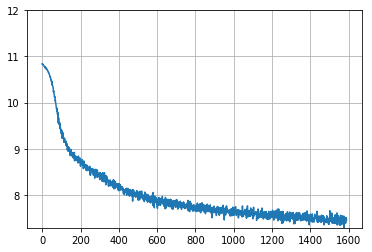

 73%|███████▎  | 1597/2200 [1:39:43<37:39,  3.75s/it]

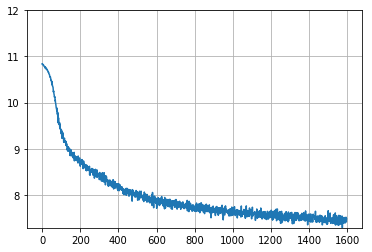

 73%|███████▎  | 1606/2200 [1:40:15<37:04,  3.75s/it]

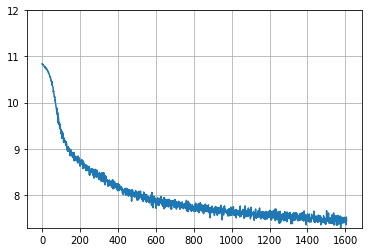

 73%|███████▎  | 1615/2200 [1:40:46<36:30,  3.74s/it]

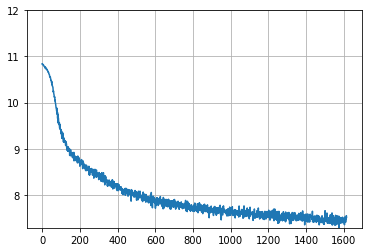

 74%|███████▍  | 1624/2200 [1:41:18<35:56,  3.74s/it]

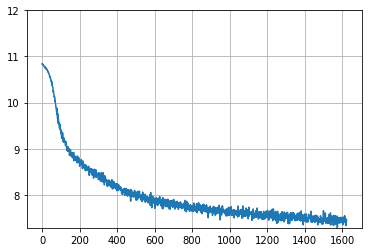

 74%|███████▍  | 1633/2200 [1:41:50<35:21,  3.74s/it]

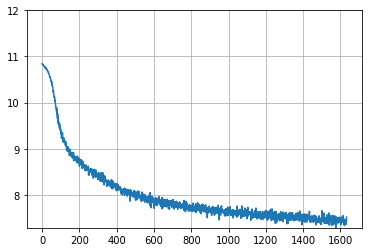

 75%|███████▍  | 1642/2200 [1:42:22<34:47,  3.74s/it]

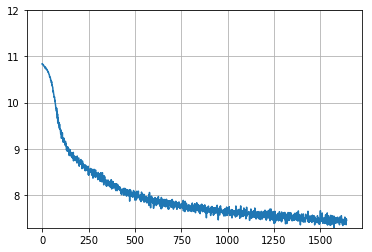

 75%|███████▌  | 1651/2200 [1:42:54<34:13,  3.74s/it]

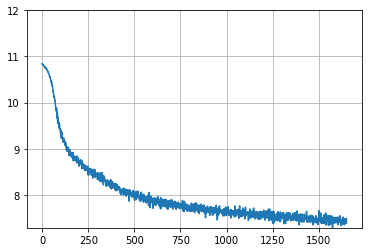

 75%|███████▌  | 1660/2200 [1:43:26<33:39,  3.74s/it]

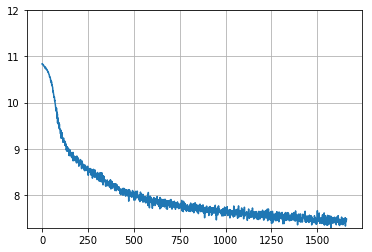

 76%|███████▌  | 1669/2200 [1:43:58<33:04,  3.74s/it]

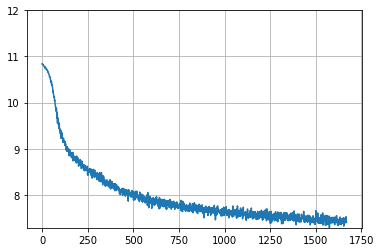

 76%|███████▋  | 1678/2200 [1:44:30<32:30,  3.74s/it]

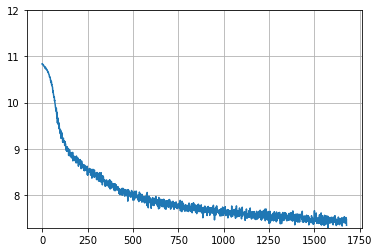

 77%|███████▋  | 1687/2200 [1:45:02<31:56,  3.74s/it]

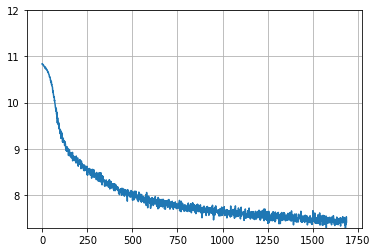

 77%|███████▋  | 1696/2200 [1:45:34<31:22,  3.73s/it]

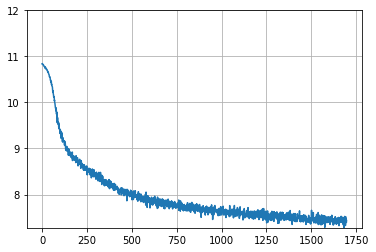

 78%|███████▊  | 1705/2200 [1:46:05<30:48,  3.73s/it]

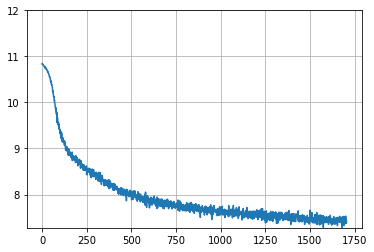

 78%|███████▊  | 1714/2200 [1:46:37<30:13,  3.73s/it]

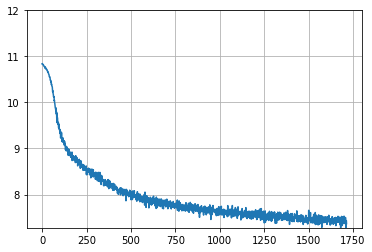

 78%|███████▊  | 1723/2200 [1:47:09<29:39,  3.73s/it]

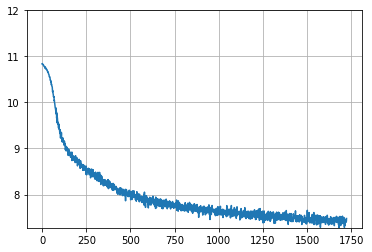

 79%|███████▊  | 1732/2200 [1:47:40<29:05,  3.73s/it]

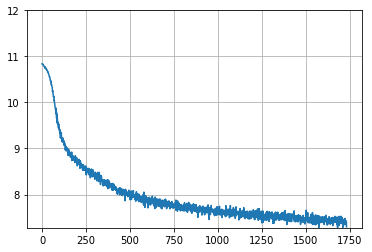

 79%|███████▉  | 1741/2200 [1:48:12<28:31,  3.73s/it]

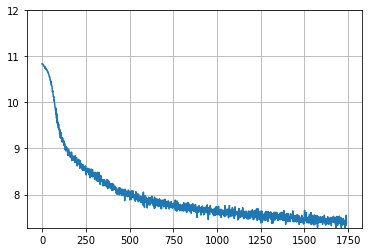

 80%|███████▉  | 1750/2200 [1:48:44<27:57,  3.73s/it]

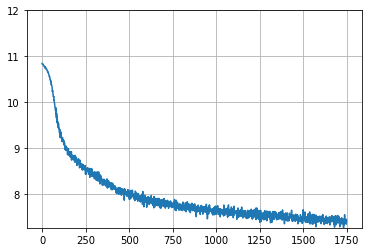

 80%|███████▉  | 1759/2200 [1:49:15<27:23,  3.73s/it]

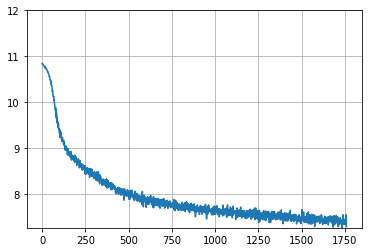

 80%|████████  | 1768/2200 [1:49:48<26:49,  3.73s/it]

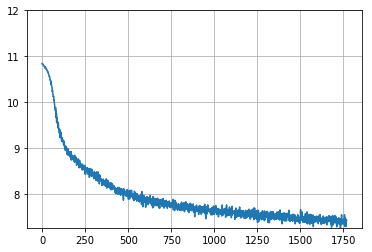

 81%|████████  | 1777/2200 [1:50:20<26:15,  3.73s/it]

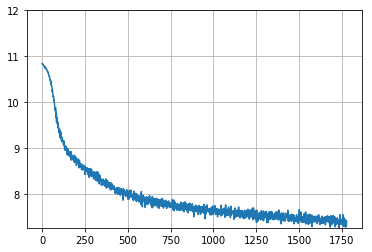

 81%|████████  | 1786/2200 [1:50:52<25:41,  3.72s/it]

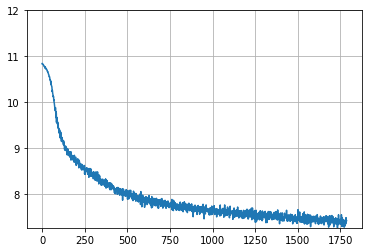

 82%|████████▏ | 1795/2200 [1:51:24<25:08,  3.72s/it]

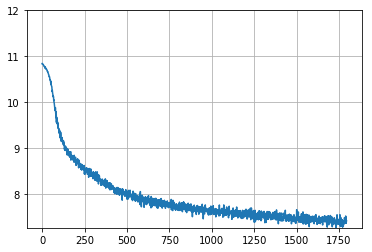

 82%|████████▏ | 1804/2200 [1:51:55<24:34,  3.72s/it]

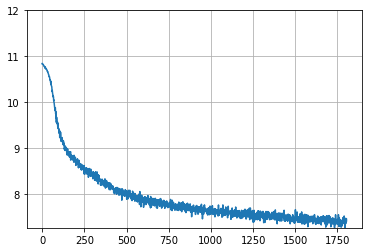

 82%|████████▏ | 1813/2200 [1:52:27<24:00,  3.72s/it]

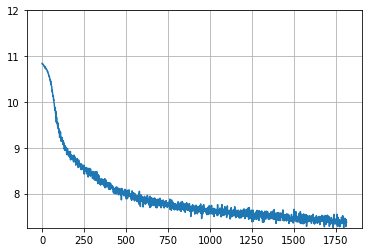

 83%|████████▎ | 1822/2200 [1:52:59<23:26,  3.72s/it]

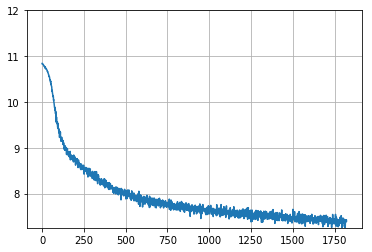

 83%|████████▎ | 1831/2200 [1:53:31<22:52,  3.72s/it]

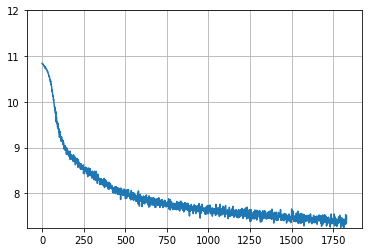

 84%|████████▎ | 1840/2200 [1:54:03<22:18,  3.72s/it]

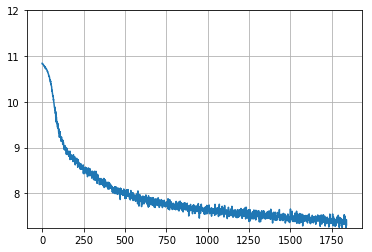

 84%|████████▍ | 1849/2200 [1:54:34<21:45,  3.72s/it]

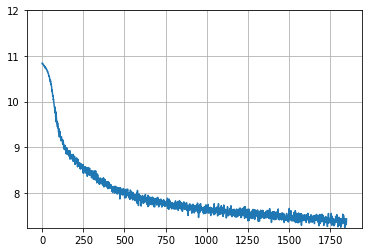

 84%|████████▍ | 1858/2200 [1:55:06<21:11,  3.72s/it]

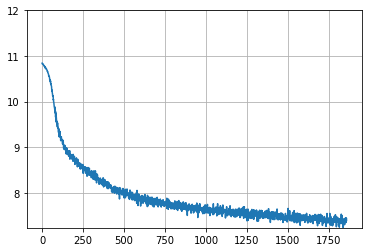

 85%|████████▍ | 1867/2200 [1:55:39<20:37,  3.72s/it]

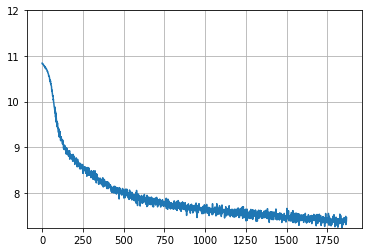

 85%|████████▌ | 1876/2200 [1:56:11<20:03,  3.72s/it]

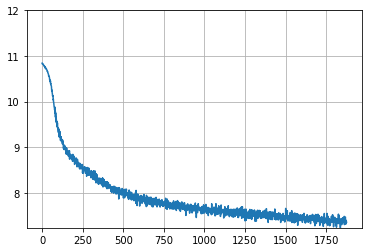

 86%|████████▌ | 1885/2200 [1:56:42<19:30,  3.72s/it]

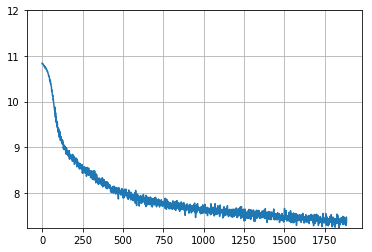

 86%|████████▌ | 1894/2200 [1:57:14<18:56,  3.71s/it]

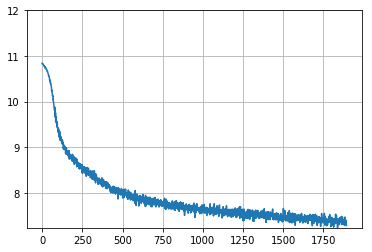

 86%|████████▋ | 1903/2200 [1:57:46<18:22,  3.71s/it]

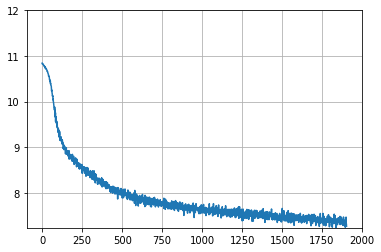

 87%|████████▋ | 1912/2200 [1:58:18<17:49,  3.71s/it]

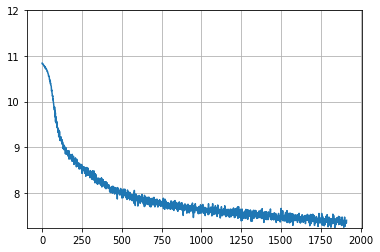

 87%|████████▋ | 1921/2200 [1:58:50<17:15,  3.71s/it]

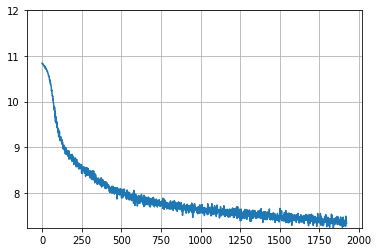

 88%|████████▊ | 1930/2200 [1:59:21<16:41,  3.71s/it]

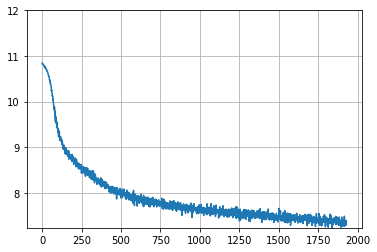

 88%|████████▊ | 1939/2200 [1:59:53<16:08,  3.71s/it]

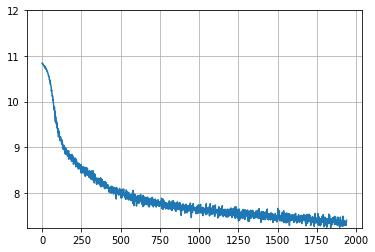

 89%|████████▊ | 1948/2200 [2:00:25<15:34,  3.71s/it]

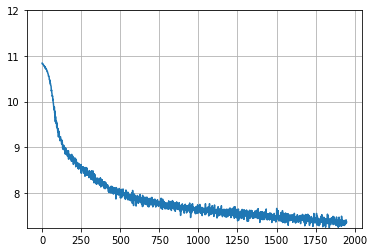

 89%|████████▉ | 1957/2200 [2:00:57<15:01,  3.71s/it]

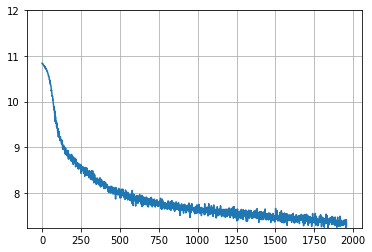

 89%|████████▉ | 1966/2200 [2:01:29<14:27,  3.71s/it]

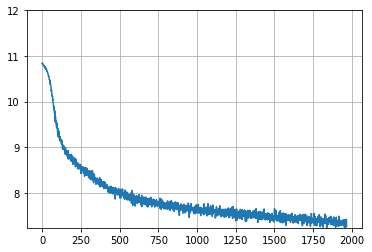

 90%|████████▉ | 1975/2200 [2:02:01<13:54,  3.71s/it]

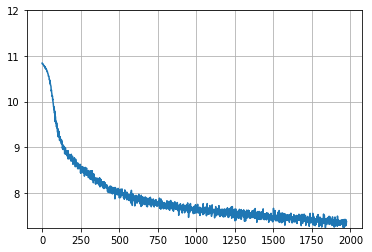

 90%|█████████ | 1984/2200 [2:02:33<13:20,  3.71s/it]

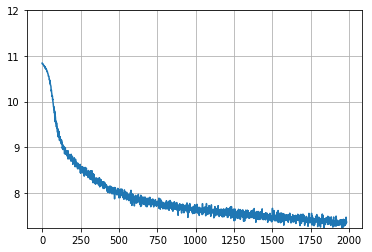

 91%|█████████ | 1993/2200 [2:03:05<12:47,  3.71s/it]

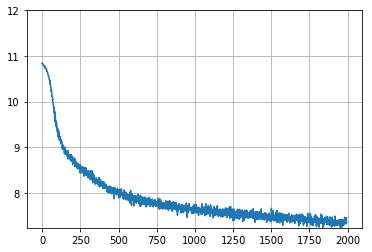

 91%|█████████ | 2002/2200 [2:03:37<12:13,  3.71s/it]

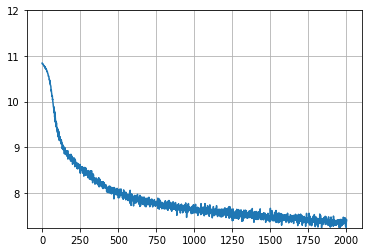

 91%|█████████▏| 2011/2200 [2:04:09<11:40,  3.70s/it]

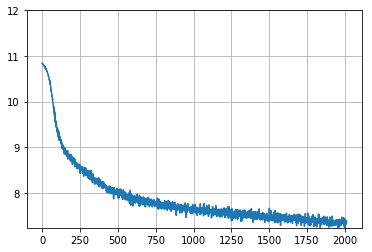

 92%|█████████▏| 2020/2200 [2:04:41<11:06,  3.70s/it]

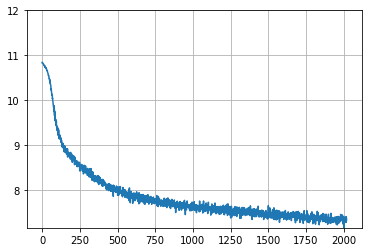

 92%|█████████▏| 2029/2200 [2:05:13<10:33,  3.70s/it]

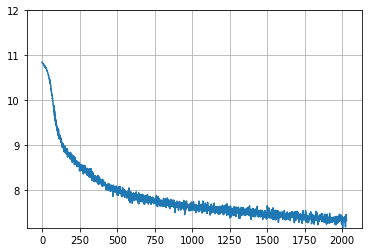

 93%|█████████▎| 2038/2200 [2:05:45<09:59,  3.70s/it]

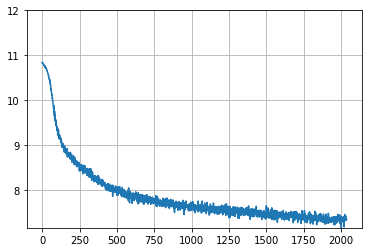

 93%|█████████▎| 2047/2200 [2:06:17<09:26,  3.70s/it]

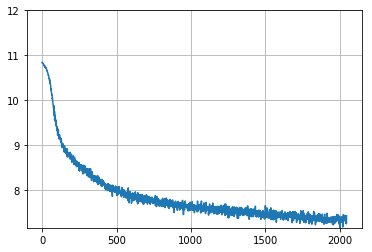

 93%|█████████▎| 2056/2200 [2:06:49<08:52,  3.70s/it]

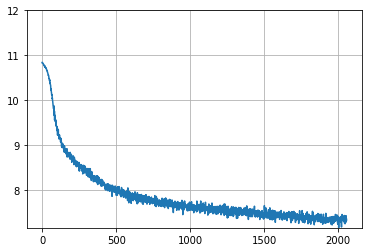

 94%|█████████▍| 2065/2200 [2:07:22<08:19,  3.70s/it]

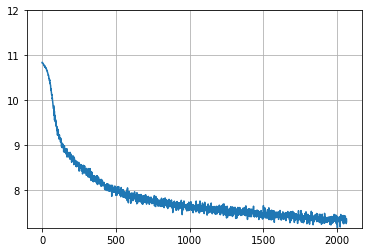

 94%|█████████▍| 2074/2200 [2:07:54<07:46,  3.70s/it]

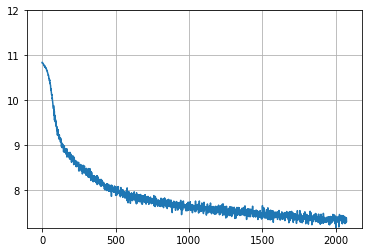

 95%|█████████▍| 2083/2200 [2:08:26<07:12,  3.70s/it]

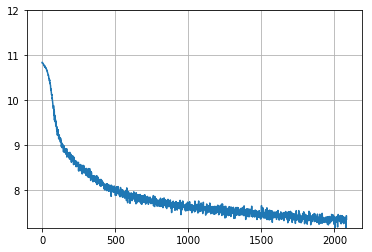

 95%|█████████▌| 2092/2200 [2:08:57<06:39,  3.70s/it]

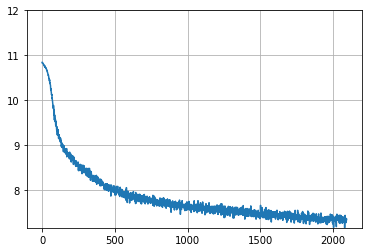

 96%|█████████▌| 2101/2200 [2:09:29<06:06,  3.70s/it]

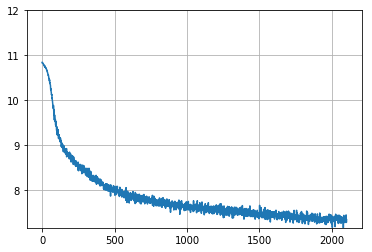

 96%|█████████▌| 2110/2200 [2:10:01<05:32,  3.70s/it]

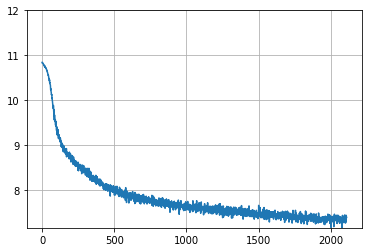

 96%|█████████▋| 2119/2200 [2:10:33<04:59,  3.70s/it]

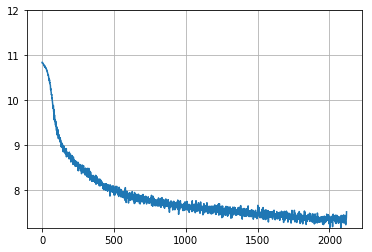

 97%|█████████▋| 2128/2200 [2:11:04<04:26,  3.70s/it]

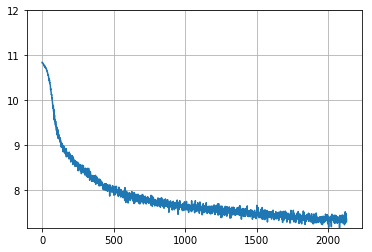

 97%|█████████▋| 2137/2200 [2:11:36<03:52,  3.70s/it]

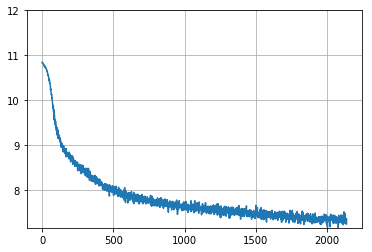

 98%|█████████▊| 2146/2200 [2:12:08<03:19,  3.69s/it]

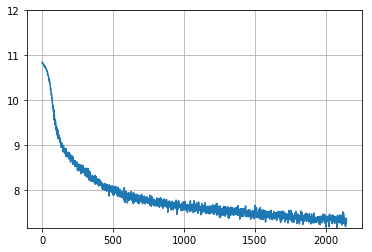

 98%|█████████▊| 2155/2200 [2:12:40<02:46,  3.69s/it]

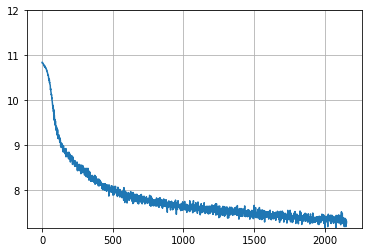

 98%|█████████▊| 2164/2200 [2:13:12<02:12,  3.69s/it]

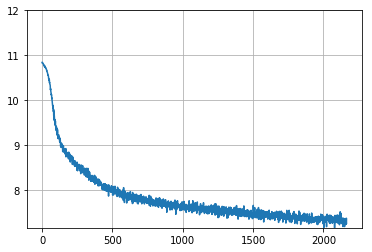

 99%|█████████▉| 2173/2200 [2:13:44<01:39,  3.69s/it]

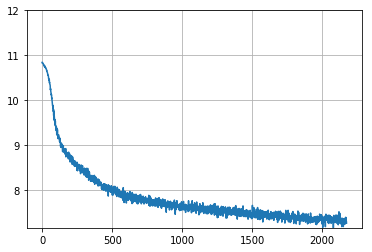

 99%|█████████▉| 2182/2200 [2:14:16<01:06,  3.69s/it]

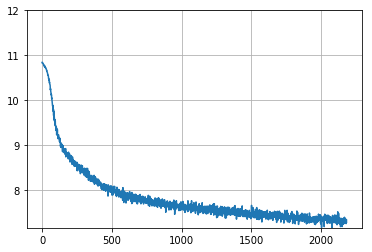

100%|█████████▉| 2191/2200 [2:14:48<00:33,  3.69s/it]

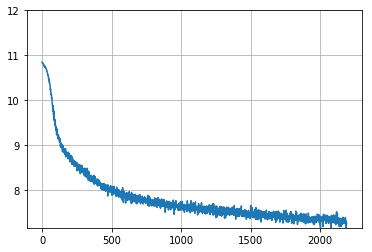

100%|██████████| 2200/2200 [2:15:20<00:00,  3.69s/it]

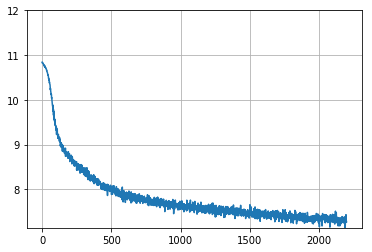

In [84]:
embedding_dim = 200
word2vec = NGramLanguageModelerLeaky(model.vocab_size, embedding_dim, context_size)
if use_gpu:
    word2vec = word2vec.cuda()
losses = []
loss_function = nn.NLLLoss()
optimizer = optim.Adam(word2vec.parameters(), lr=0.0001)
num_epochs = 5
batch_size = 2**11
t_start = datetime.now()
tstep = timedelta(seconds=30) # Время между отрисовками функции потерь
plt.figure()
for epoch in tqdm_notebook(range(num_epochs)):
    total_loss = torch.Tensor([0])
    for X, y in iterate_minibatches(context, target, batch_size, shuffle=True):
        word2vec.zero_grad()
        if use_gpu:
            X = Variable(X.cuda())
            y = Variable(y.cuda())
        else:
            X = Variable(X)
            y = Variable(y)
        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = word2vec(X)
        

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a variable)
        #print(log_probs.shape, y.shape)
        loss = loss_function(log_probs, y)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        losses.append(loss.data.numpy())
        total_loss += loss.data
        #print(loss.data)
        if datetime.now() - t_start > tstep:
            #clear_output()
            #plt.clf()
            plt.plot(losses)
            plt.show()
            plt.grid()
            plt.ylim([min(losses), 12])
            t_start = datetime.now()
    #losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!
plt.plot(losses)
torch.save(word2vec.state_dict(), 'word2vec_%i_epochs_%i_dims_leaky.pth'%(num_epochs, embedding_dim))